<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Artem%20Dunaev/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Recomendation_System_Prof_Dunaev_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Рекомендательная система для профпатологов. INSPECTRUM CLINIC.**
Цели. Тех. Задание

Цель:
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы:
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования интерфейсу:
Минимальный уровень реализации: notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

Дополнительно: передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования к скорости работы:
Не предъявляются

Требования к тестированию, метрикам качества:
Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Подгружаем библиотеки, инструменты для работы, а также базу заказчика и дополнительную таблицу из приказа N29
Работа проводится в googlecolab\jupiter-nootbook

Обратите внимание на серьезную разбалансировку данных (несмотря на новый датасет кол-во примеров по классам все еще незначительно). Предсавителей класса - "Годен" больше всего в таблице, что вызывает затруднения в обучении НС (ей станет проще ставить везде "годен", чтобы получить высокую точность), при этом класса "НЕ ГОДЕН", как такового не существует, вместо него "ВременноНегоден". Также есть такие классы, как "НуждаетсяВДообследованииИЛечении", "ОграниченноГоден", "ГоденСКоррекциейЗрения" и др., что говорит об условности этих самых классов. Приказ РФ от 28 января 2021 г. N 29н содержит такую фразу "перечня медицинских противопоказаний к осуществлению работ с вредными и (или) опасными производственными факторами", а также не содержит таких слов как годен или негоден.
В любом случае по желанию заказчика система сделана под 3 класса, благодаря новым данным точность стала выше

In [ ]:
%matplotlib inline

import pandas as pd #табличные данные
import matplotlib.pyplot as plt #графики
from tensorflow.keras import utils #утилиты
from tensorflow.keras.models import Sequential, Model #модель
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, concatenate #слои
from tensorflow.keras.optimizers import Adam, Adadelta #оптимизаторы
from tensorflow.keras.metrics import Precision #метрики
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split #разделитель данных
from keras.layers import Embedding, Flatten
from keras.utils import to_categorical
import seaborn as sns
import numpy as np #нампи
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json #токенизатор

from sklearn.preprocessing import StandardScaler, LabelEncoder #может пригодиться

import time
import re

In [ ]:
from google.colab import drive #подключаю диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/NEW.xlsx') #читаем предоставленную таблицу заказчика

In [ ]:
df.head(3)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,79292387-652a-11eb-80e7-0cc47aab8067,dca98d4e-2098-11ea-80d6-0cc47aab8067,1989-12-31 00:00:00,Женский,Женский,2021-02-02,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1998-07-20 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,2002-01-04 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_list = df.columns.tolist() #список столбцов
print(column_list)

['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение', 'ВредныеФакторы', 'Гинекология1_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103', 'Гинекология2_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология2_МКБ101', 'Гинекология2_МКБ102', 'Гинекология2_МКБ103', 'Гинекология3_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология3_МКБ101', 'Гинекология3_МКБ102', 'Гинекология3_МКБ103', 'Гинекология4_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология4_МКБ101', 'Гинекология4_МКБ102', 'ГинекологНеИсп1_Диагноз_ЗначениеПредставлениеПредставление', 'ГинекологНеИсп1_МКБ101', 'Дерматовенерология1_Диагноз_ЗначениеПредставлениеПредставление', 'Дерматовенерология1_МКБ101', 'Дерматов

In [ ]:
# Получение уникальных значений и их количества по ключебому столбцу
unique_values = df['ЗаключениеМК'].unique()
count_values = df['ЗаключениеМК'].value_counts()

# Вывод уникальных значений и их количества
print("Уникальные значения:")
print(unique_values)
print("Количество каждого значения:")
print(count_values)

Уникальные значения:
['Годен' 'ГоденСКоррекциейЗрения' 'НуждаетсяВДообследованииИЛечении' nan
 'ГоденБезРаботНаВысотах' 'ГоденСКоррекциейСлуха' ' п. 11.3'
 'ОграниченноГоден' 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'
 'Негоден']
Количество каждого значения:
Годен                               17982
ГоденСКоррекциейЗрения               1114
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Газоспасатель                           2
 п. 11.3                                1
машинист бульдозера                     1
 Газоспасатель                          1
Name: ЗаключениеМК, dtype: int64


# **Загружаем обработанную таблицу из приказа н29 и работаем с ней**
Таблица была скопирована из приказа 29 и переделана под нашу конкретную задачу. Все действия были проделаны с таблицей вручную.

-коды мкб приведены к виду списка кодов вместо диапазона: А1-А3......A1, A2, A3

-оставлены только заголовки мкб: к примеру не "O99.1", а "O99". В дальнейшем можно изменить этот подход

-Диапазоны вредных факторов и видов работ также приведены к новому виду вместо диапазона вредных факторов - их список в соответствии с перечнем приведенным в приказе: вместо -[1.30 - 1.33]..... -1.30, 1.30.1, 1.31, 1.32, 1.33

-добавлен новый столбец "класс"

-есть неприятная особенность - коды мкб выставлены в заголовки диапазоном (в приказе н29), и зачастую есть несоответствие кода и вредных факторов (он в том же диапазоне, но уже подходит под другие факторы), также есть подразделение одних и тех же кодов на легкие и тяжелые формы заболеваний, соответственно с разным перечнем вредных факторов и видов работ, что может определяться только врачом. Если бы была таблица с подробным подразделением по заболеваниям все было бы намного проще, но для этого нужен специалист по профпатологии, желательно профессионал, желательно мотивированный, моих знаний по терапии будет недостаточно для понимания всех нюансов, в любом случае со своей стороны, мне удалось перебрать таблицу и сопоставить некоторые диагнозы, коды мкб и вредные факторы так чтобы это не создавало проблем в работе модели и поддерживало высокую точность, при этом в таблице появляются новые случаи заболеваний которые редко встречаются в практике, но благодаря тому, что система их видела, модель выдвинет свою рекомендацию.

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29.xlsx') #читаем таблицу приказа n29 для последующей аугментации

In [ ]:
#mkb_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/mkb10.xls') #читаем таблицу мкб

In [ ]:
#mkb_data.head(3)

In [ ]:
dop_data.head(3)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,"А00, А01, А02, А03, А04, А05, А06, А07, А08, А09",NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Активный туберкулез органов дыхания; последств...,"А15, А16, А17, А18, А19","1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Сифилис в заразном периоде,"А50, А51, А52, А53",NaN,"19, 19.1, 19.2, 19.3, 20, 21, 23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN


In [ ]:
# Разделение значений столбца "МКБ" по запятой
dop_data['МКБ'] = dop_data['МКБ'].str.split(', ')

# Дублирование строк с разделенными значениями столбца "МКБ"
dop_data = dop_data.explode('МКБ')

# Вывод полученной таблицы
dop_data.head(15)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,А00,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А01,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А02,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А03,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А04,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А05,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А06,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А07,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А08,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
0,Кишечные инфекции,А09,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN


In [ ]:
dop_data.reset_index(drop=True)

,Наименование_болезни,МКБ,Вредные_факторы,Виды_работ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК
0,Кишечные инфекции,А00,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
1,Кишечные инфекции,А01,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
2,Кишечные инфекции,А02,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
3,Кишечные инфекции,А03,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
4,Кишечные инфекции,А04,NaN,"23, 24, 25, 26, 27",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1856,"Последствия травм, отравлений, других воздейст...",Т94,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1857,"Последствия травм, отравлений, других воздейст...",Т95,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1858,"Последствия травм, отравлений, других воздейст...",Т96,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN
1859,"Последствия травм, отравлений, других воздейст...",Т97,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....","6, 6.1, 6.2, 7, 8, 9, 10, 11, 11.1, 11.2, 11.3...",NaN,NaN,NaN,NaN,NaN


таким образом, как видно в таблице выше, я создаю новые случаи заболеваний и соответствующие им факторы риска-виды работ. Таблица требует доработки и экспертного взгяляда. Пока логичным будет создание 2 классов на большем кол-ве классов система будет часто ошибаться.

In [ ]:
# Преобразуем значения в столбцах в строки
dop_data['Вредные_факторы'] = dop_data['Вредные_факторы'].astype(str)
dop_data['Виды_работ'] = dop_data['Виды_работ'].astype(str)

In [ ]:
dop_data['факторы'] = dop_data['Вредные_факторы'].fillna('') + ', ' + dop_data['Виды_работ']

In [ ]:
dop_data = dop_data.drop(['Вредные_факторы', 'Виды_работ'], axis=1)

In [ ]:
# Разделяем строку по запятым и удаляем значение NaN
dop_data['факторы'] = dop_data['факторы'].str.split(', ').apply(lambda x: ', '.join([i for i in x if i != 'nan']))

# Удаляем строки, где значение в столбце "факторы" является пустой строкой
dop_data = dop_data[dop_data['факторы'] != '']

In [ ]:
dop_data = dop_data.reset_index(drop=True)

In [ ]:
dop_data

,Наименование_болезни,МКБ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК,факторы
0,Кишечные инфекции,А00,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
1,Кишечные инфекции,А01,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
2,Кишечные инфекции,А02,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
3,Кишечные инфекции,А03,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
4,Кишечные инфекции,А04,NaN,NaN,NaN,NaN,NaN,"23, 24, 25, 26, 27"
...,...,...,...,...,...,...,...,...
1856,"Последствия травм, отравлений, других воздейст...",Т94,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1857,"Последствия травм, отравлений, других воздейст...",Т95,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1858,"Последствия травм, отравлений, других воздейст...",Т96,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1859,"Последствия травм, отравлений, других воздейст...",Т97,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."


In [ ]:
#new_cells = mkb_data['mkb_cod'].tolist()

In [ ]:
# Преумножаем таблицу, сделав копии элементов
#dop_data_repeated = dop_data.loc[dop_data.index.repeat(3)].reset_index(drop=True)

In [ ]:
#dop_data_repeated.head(3)

In [ ]:
# Сохранение в файл Excel и дорабатываем вручную
dop_data.to_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29(for_change).xlsx', index=False)

In [ ]:
dop_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/fromN29(for_change).xlsx')

In [ ]:
# Перемешиваем строки
dop_data_repeated_shuffled = dop_data.sample(frac=1).reset_index(drop=True)

In [ ]:
dop_data_repeated_shuffled

,Наименование_болезни,МКБ,Цех,Профессия,КлиентДатаРождения,КлиентПол,ЗаключениеМК,факторы
0,Злокачественные новообразования всех органов и...,С82,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1,"Болезни артерий, артериол, капилляров, вен, ли...",I84,NaN,NaN,NaN,NaN,NaN,"5.1, 10, 11, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22"
2,"аномалии, деформации, хромосомные нарушения с ...",Q45,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
3,беременность и период лактации,О90,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
4,"Болезни печени, желчного пузыря, желчевыводящи...",К86,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
...,...,...,...,...,...,...,...,...
1856,Болезни мочеполовой системы с хронической поче...,N18,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1857,Болезни мочеполовой системы с хронической поче...,N61,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."
1858,Воспалительные заболевания центральной нервной...,G00,NaN,NaN,NaN,NaN,NaN,1.52.6
1859,Злокачественные новообразования всех органов и...,С97,NaN,NaN,NaN,NaN,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...."


In [ ]:
#проставим случайно профессии
import random

# Перечень профессий
professions = ['специалист', 'инженер', 'программист', 'машинист', 'администратор', 'лаборант',
    'бригадир', 'водитель', 'санитар', 'методист', 'кладовщик', 'маляр', 'бухгалтер', 'уборщик',
    'мастер', 'охранник', 'официант']

# Функция для выбора случайной профессии из перечня
def random_profession(row):
    if any(factor in row['факторы'] for factor in ['19', '23', '24', '25', '26', '27']):
            return random.choice(['повар', 'пекарь', 'кок', 'водопроводчик', 'воспитатель', 'учитель',
                                  'работник бытового обслуживания', 'медсестра', 'врач', 'сантехник', 'водолаз'])
    elif any(factor in row['факторы'] for factor in ['11', '12', '13']):
        return random.choice(['взрывник', 'нефтяник', 'вахтовик','бурильщиу'])
    elif any(factor in row['факторы'] for factor in ['4.1', '4.2']):
        return 'рентгенолог'
    elif row['факторы'] == '19':
        return 'водолаз'
    elif row['факторы'] == '5.2.2':
        return random.choice(['лектор', 'воспитатель', 'экскурсовод', 'гид'])
    else:
        return random.choice(professions)

# Применение функции к каждой строке
dop_data_repeated_shuffled['Профессия'] = dop_data_repeated_shuffled.apply(random_profession, axis=1)

In [ ]:
# Функция для выбора цеха
def set_workshop(row):
    profession = row['Профессия']
    if profession in ['врач', 'медсестра', 'санитар', 'рентгенолог']:
        return random.choice(['поликлиника', 'больница'])
    elif profession in ['повар', 'пекарь', 'кок']:
        return random.choice(['кухня', 'столовая', 'кафе'])
    elif profession in ['сантехник', 'работник бытового обслуживания', 'водопроводчик']:
        return 'Административно-хозяйственный'
    elif profession in ['воспитатель', 'учитель', 'лектор']:
        return random.choice(['училище', 'детский сад', 'университет', 'школа'])
    # Добавьте остальные условия для остальных профессий и соответствующих цехов
    else:
        return row['Цех']

# Применение функции к каждой строке
dop_data_repeated_shuffled['Цех'] = dop_data_repeated_shuffled.apply(set_workshop, axis=1)

**Это примерная функция для подстановки конкретной профессии и цеха конкретному виду работ. к примеру подставив профессии 'повар', 'пекарь', 'кок' к строкам с парами вредный фактор-диагноз, которые препятствуют такой работе, мы получим явное несоответствие пациента исполняемым трудовым обязательствам**

In [ ]:
def set_random_gender():
    return random.choice([0, 1])

# Применение функции пола к каждой строке
dop_data_repeated_shuffled['КлиентПол'] = dop_data_repeated_shuffled['КлиентПол'].apply(lambda x: set_random_gender() if pd.isnull(x) else x)

In [ ]:
from datetime import datetime, timedelta

# Функция для генерации случайной даты в указанном диапазоне
def generate_random_date():
    start_date = datetime(1970, 1, 1)
    end_date = datetime(2004, 1, 1)

    random_days = random.randint(0, (end_date - start_date).days)
    random_date = start_date + timedelta(days=random_days)

    return random_date.strftime('%d.%m.%Y')

# Применение функции к каждой строке
dop_data_repeated_shuffled['КлиентДатаРождения'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(lambda x: generate_random_date() if pd.isnull(x) else x)

In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")
dop_data_repeated_shuffled["Возраст"] = \
    (pd.to_datetime("today") - dop_data_repeated_shuffled["КлиентДатаРождения"]).astype('<m8[Y]')

<ipython-input-244-6d75b1f623a1>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dop_data_repeated_shuffled['КлиентДатаРождения'] = pd.to_datetime(dop_data_repeated_shuffled['КлиентДатаРождения'], errors="coerce")


In [ ]:
dop_data_repeated_shuffled['КлиентДатаРождения']=dop_data_repeated_shuffled["Возраст"]

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='Возраст')

In [ ]:
dop_data_repeated_shuffled["КлиентДатаРождения"]=dop_data_repeated_shuffled["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
dop_data_repeated_shuffled['ВозрастКатегория'] = dop_data_repeated_shuffled['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.drop(columns='КлиентДатаРождения')

In [ ]:
dop_data_repeated_shuffled

,Наименование_болезни,МКБ,Цех,Профессия,КлиентПол,ЗаключениеМК,факторы,ВозрастКатегория
0,Злокачественные новообразования всех органов и...,С82,Административно-хозяйственный,водопроводчик,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",5
1,"Болезни артерий, артериол, капилляров, вен, ли...",I84,Административно-хозяйственный,работник бытового обслуживания,1,NaN,"5.1, 10, 11, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22",8
2,"аномалии, деформации, хромосомные нарушения с ...",Q45,Административно-хозяйственный,сантехник,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",1
3,беременность и период лактации,О90,Административно-хозяйственный,водопроводчик,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",3
4,"Болезни печени, желчного пузыря, желчевыводящи...",К86,NaN,водолаз,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
...,...,...,...,...,...,...,...,...
1856,Болезни мочеполовой системы с хронической поче...,N18,кафе,пекарь,0,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",3
1857,Болезни мочеполовой системы с хронической поче...,N61,столовая,кок,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",6
1858,Воспалительные заболевания центральной нервной...,G00,NaN,бухгалтер,1,NaN,1.52.6,5
1859,Злокачественные новообразования всех органов и...,С97,больница,врач,1,NaN,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",4


In [ ]:
dop_data_repeated_shuffled['ЗаключениеМК'] = 1

# **Работаем с таблицей заказчика. очистка данных от мусора. добавление новых данных в соответствии с приказом**

In [ ]:
df_1 = df.dropna(axis=0, how='all') #удаляем пустые строки и столбцы
df_2 = df_1.dropna(axis=1, how='all')

In [ ]:
df_2

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,79292387-652a-11eb-80e7-0cc47aab8067,dca98d4e-2098-11ea-80d6-0cc47aab8067,1989-12-31 00:00:00,Женский,Женский,2021-02-02,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1998-07-20 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,2002-01-04 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,941e4b56-9c2d-11eb-80eb-0cc47aab8067,7ea364a1-9c2d-11eb-80eb-0cc47aab8067,1991-08-26 00:00:00,Женский,Женский,2021-04-13,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5a24806c-f033-11eb-80f6-0cc47aab8067,52eb6a7d-c1ab-11ea-80dd-0cc47aab8067,1999-03-21 00:00:00,Женский,Женский,2021-07-29,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,0dc1a36a-0e78-11ee-8133-0cc47aab8067,c31ae865-e5bb-11ed-812b-0cc47aab8067,1971-06-04 00:00:00,Мужской,Мужской,2023-06-19,Периодический,Периодический,False,2e01d3ec-615e-11eb-80e7-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32682,43a376cb-0e53-11ee-8133-0cc47aab8067,71fb1a04-28f6-11e7-80d5-708bcd7f83cd,1978-12-12 00:00:00,Мужской,Мужской,2023-06-19,Периодический,Периодический,False,e935abf8-4ed4-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32683,f2163f48-0e61-11ee-8133-0cc47aab8067,c5c58eaf-cb1b-11ea-80e0-0cc47aab8067,1995-01-27 00:00:00,Женский,Женский,2023-06-19,Периодический,Периодический,False,250639b6-68c4-11e8-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32684,346a9c13-0e65-11ee-8133-0cc47aab8067,d942cc21-e669-11ec-8102-0cc47aab8067,1975-02-18 00:00:00,Мужской,Мужской,2023-06-19,Периодический,Периодический,False,c9d539ae-91a3-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_list = df_2.columns.tolist()

In [ ]:
column_list

['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ЗаключениеМКПредставление',
 'Заключение',
 'ВредныеФакторы',
 'Гинекология1_Диагноз_ЗначениеПредставлениеПредставление',
 'Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология1_МКБ103',
 'Гинекология2_Диагноз_ЗначениеПредставлениеПредставление',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102',
 'Гинекология2_МКБ103',
 'Гинекология3_МКБ101',
 'Гинекология3_МКБ102',
 'Гинекология3_МКБ103',
 'Гинекология4_МКБ101',
 'Гинекология4_МКБ102',
 'ГинекологНеИсп1_МКБ101',
 'Дерматовенерология1_МКБ101',
 'Дерматовенерология1_МКБ102',
 'Дерматовенерология1_МКБ103',
 'Дерматовенерология2_Диагноз_ЗначениеПредставлениеПредставление',
 'Дерматовенерология2_МКБ101',
 'Дерматовенерология2_МКБ102',
 'Дерматовенерология2_МКБ103',
 'Д

In [ ]:
df_list_1 = [] #создаем список колонок содержащих КОД МКБ
for i in column_list:
  if "МКБ" in i:
    df_list_1.append(i)

In [ ]:
print(df_list_1)

['Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103', 'Гинекология2_МКБ101', 'Гинекология2_МКБ102', 'Гинекология2_МКБ103', 'Гинекология3_МКБ101', 'Гинекология3_МКБ102', 'Гинекология3_МКБ103', 'Гинекология4_МКБ101', 'Гинекология4_МКБ102', 'ГинекологНеИсп1_МКБ101', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_МКБ102', 'Дерматовенерология1_МКБ103', 'Дерматовенерология2_МКБ101', 'Дерматовенерология2_МКБ102', 'Дерматовенерология2_МКБ103', 'Дерматовенерология3_МКБ101', 'Дерматовенерология3_МКБ102', 'Дерматовенерология3_МКБ103', 'Дерматовенерология4_МКБ101', 'Дерматовенерология4_МКБ102', 'ДерматовенерологНеИсп1_МКБ101', 'ДерматовенерологНеИсп1_МКБ102', 'ДерматовенерологНеИсп2_МКБ101', 'ДерматовенерологНеИсп2_МКБ102', 'ЛабораторнаяДиагностика1_МКБ101', 'ЛабораторнаяДиагностика2_МКБ101', 'ЛабораторныеИсследования1_МКБ101', 'ЛабораторныеИсследования1_МКБ102', 'ЛабораторныеИсследования1_МКБ103', 'ЛабораторныеИсследования2_МКБ101', 'ЛабораторныеИсследования2_МКБ102', 'Лаборат

_______________________________

In [ ]:
#df_list_di = [] #создаем список колонок с ДИАГНОЗОМ В ТЕКСТЕ
#for i in column_list:
#  if "Диагноз_ЗначениеПредставление" in i:
#    df_list_di.append(i)

In [ ]:
#print(df_list_di)

['Гинекология1_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология2_Диагноз_ЗначениеПредставлениеПредставление', 'Дерматовенерология2_Диагноз_ЗначениеПредставлениеПредставление', 'Дерматовенерология3_Диагноз_ЗначениеПредставлениеПредставление', 'Неврология2_Диагноз_ЗначениеПредставлениеПредставление', 'ПсихиатрияНаркология2_Диагноз_ЗначениеПредставлениеПредставление', 'Стоматология2_Диагноз_ЗначениеПредставлениеПредставление', 'Хирургия2_Диагноз_ЗначениеПредставлениеПредставление']


_______________________________

______________________

# **Поработаем с текстовым представлением диагноза**
В данном разделе мы создаем единый столбец всех текстовых диагнозов, попутно убирая дубликаты и мусор, и оставляя только значимый диагноз если имеются диагнозы кроме Z00

Делается сводный столбец со всеми диагнозами. одинаковые-дублирующие друг друга данные убираются.

In [ ]:
#df2_DI=df_2[df_list_di]

In [ ]:
#df2_DI.head(2)

In [ ]:
# Удаление повторяющихся значений в столбцах
#df2_DI = df2_DI.replace("_x000D_\\n", " ", regex=True).replace("nan", " ", regex=True)

In [ ]:
#df2_DI = df2_DI.astype(str)

In [ ]:
# Функция для удаления значений в квадратных скобках из строки
#def remove_brackets(text):
#    return re.sub(r'\[.*?\]', ' ', text)

# Применение функции к каждой ячейке в DataFrame
#df2_DI = df2_DI.applymap(remove_brackets)

In [ ]:
#def combine_values(row):
#    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
#    return combined_values

# Применение функции к каждой строке таблицы
#df2_DI['Диагноз_текстом'] = df2_DI.apply(combine_values, axis=1)

#df2_DI

In [ ]:
#df2_DI = df2_DI.drop(columns=df_list_di)

In [ ]:
#df2_DI

In [ ]:
#df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
#df2_DI = df2_DI.replace(',,,', ',', regex=True)

In [ ]:
#df2_DI = df2_DI.replace(',,', ',', regex=True)

In [ ]:
#def remove_Ob_med(row):
#    values = row.split(',')
#    if 'Общий медицинский осмотр' in values and len(values) > 1:
#        values.remove('Общий медицинский осмотр')
#    return ','.join(values)

#df2_DI['Диагноз_текстом'] = df2_DI['Диагноз_текстом'].apply(remove_Ob_med)

In [ ]:
#df2_DI

In [ ]:
#df2_DI = df2_DI.replace(',', ', ', regex=True)

In [ ]:
#unique_values = df2_DI['Диагноз_текстом'].unique()

# Вывод уникальных значений
#print(unique_values)

Таким образом при помощи кода выше мы объединяем столбцы в единый по текстовому описанию диагноза и уничтажаем "Общий медицинский осмотр", если и так есть серьезный диагноз, во избежание путаницы. В остальных случаях, когда в столбце только представители класса "Общий медицинский осмотр", он останется.

__________________________________

# **Поработаем с МКБ**
В данном разделе мы очищаем столбцы от мусора, объединяем столбцы с мкб в один попутно убирая дубликаты и оставляя только значимые диагнозы (отличные от Z00)

одинаковые-дублирующие друг друга данные убираются. Делается сводный столбец со всеми кодами МКБ выставленными узкими специалистами

In [ ]:
df2_MKB=df_2[df_list_1]

In [ ]:
df2_MKB

,Гинекология1_МКБ101,Гинекология1_МКБ102,Гинекология1_МКБ103,Гинекология2_МКБ101,Гинекология2_МКБ102,Гинекология2_МКБ103,Гинекология3_МКБ101,Гинекология3_МКБ102,Гинекология3_МКБ103,Гинекология4_МКБ101,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Z00.0,NaN,NaN,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32683,Z00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for column in df2_MKB.columns:
    # Применение метода str.extract() с регулярным выражением для извлечения значений до точки
    df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')

<ipython-input-261-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')
<ipython-input-261-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_MKB[column] = df2_MKB[column].str.extract(r'([^.]*)')
<ipython-input-261-b31b54820d4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [ ]:
df2_MKB

,Гинекология1_МКБ101,Гинекология1_МКБ102,Гинекология1_МКБ103,Гинекология2_МКБ101,Гинекология2_МКБ102,Гинекология2_МКБ103,Гинекология3_МКБ101,Гинекология3_МКБ102,Гинекология3_МКБ103,Гинекология4_МКБ101,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,Z00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Z00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Z00,NaN,NaN,Z00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Z00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32683,Z00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2_MKB=df2_MKB.astype(str)

In [ ]:
def combine_values(row):
    combined_values = ','.join(row.dropna().astype(str).str.strip().unique())
    return combined_values

# Применение функции к каждой строке таблицы
df2_MKB['МКБ'] = df2_MKB.apply(combine_values, axis=1)

In [ ]:
df2_MKB = df2_MKB.drop(columns=df_list_1)

In [ ]:
df2_MKB

,МКБ
0,"Z00,nan"
1,"Z00,nan"
2,"Z00,nan"
3,"Z00,nan"
4,"Z00,nan"
...,...
32681,nan
32682,"nan,Z00"
32683,"Z00,nan"
32684,"nan,Z00,I11"


In [ ]:
df2_MKB['МКБ'] = df2_MKB['МКБ'].fillna('').str.replace('nan', '').str.strip(',')

In [ ]:
df2_MKB

,МКБ
0,Z00
1,Z00
2,Z00
3,Z00
4,Z00
...,...
32681,
32682,Z00
32683,Z00
32684,"Z00,I11"


In [ ]:
df2_MKB = df2_MKB.replace(',,', ',', regex=True)

In [ ]:
def remove_z00(row):
    values = row.split(',')
    if 'Z00' in values and len(values) > 1:
        values.remove('Z00')
    return ','.join(values)

df2_MKB['МКБ'] = df2_MKB['МКБ'].apply(remove_z00)

In [ ]:
df2_MKB

,МКБ
0,Z00
1,Z00
2,Z00
3,Z00
4,Z00
...,...
32681,
32682,Z00
32683,Z00
32684,I11


In [ ]:
df2_MKB = df2_MKB.replace(',', ', ', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\[",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("\]",'', regex=True)

In [ ]:
df2_MKB = df2_MKB.replace("Амбулаторная помощь при необходимости,",'', regex=True)

In [ ]:
unique_values = df2_MKB['МКБ'].unique()

# Вывод уникальных значений
print(unique_values.tolist())

['Z00', 'K29', 'H52', 'I11', 'H11', 'M42', 'M42, I11', 'N88', '', 'H52, I11', 'I11, K29', 'H52, K20', 'I83', 'H52, I49', 'I34', 'K42', 'M42, H52', 'H90, H52', 'H30, I11', 'H53, I11', 'G25, H52, I34', 'H52, I05', 'H90, I11', 'E66', 'J45', 'G25, I11', 'K20', 'G90', 'E66, K29, K76', 'E14', 'D25, I11', 'K26', 'Н27, I11', 'J44', 'H25, F06, F10, I11', 'I11, I83', 'H31, I11', 'H90', 'M51', 'H74, I11', 'H53', 'H52, I12, I11', 'I11, I25', 'I49', 'J30', 'H91, H50, I11', 'H74, H52', 'H91', 'H11, I11', 'H50', 'I25', 'G25, H52', 'T90', 'R25, I25, I11', 'L30, H52', 'G25', 'H33', 'J32', 'H02', 'H60, H52, I11', 'E11, I11', 'T90, H52', 'H52, K80', 'H52, K26', 'L40, H52', 'H65, H66', 'H50, H52', 'H52, H53', 'K91', 'H52, I11, J45', 'I11, K26', 'I69, H52, I11', 'H27', 'K80', 'H52, I11, K26, K81', 'H27, H52, I11', 'I11, I44', 'Z32', 'H66, H52', 'H52, I11, I49', 'H52, I11, K29', 'H53, K26', 'K04', 'L40', 'I67, I25', 'H52, K86', 'H40, K26', 'J30, I11', 'F60, I11', 'H74', 'H40', 'H52, K29', 'H74, K29', 'I67, 

In [ ]:
df2_MKB['МКБ'] = df2_MKB['МКБ'].replace('', np.nan)

Таким образом как вы видете выше. Мы получаем столбец с "чистым мкб". Убираются все дубликаты кода МКБ, к примеру если имеем множество из Z00, зачем нам такое множество? Или если есть Z00 и серьезный диагноз оставляем только серьезный диагноз или список серьезных диагнозов в ячейке

# **Объединяем разобранные по отдельности разделы, а также редактируем вредные факторы-виды работ, где вместо них стоит дата**

In [ ]:
df4=df[[
  'КлиентДатаРождения',
  'КлиентПол',
  'Цех',
  'Профессия',
  'ЗаключениеМК',
  'ВредныеФакторы']]

In [ ]:
df_full=pd.concat([df4, df2_MKB], axis=1, sort=False)

In [ ]:
df_full.fillna(0, inplace=True)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1989-12-31 00:00:00,Женский,0,Продавец-кассир,Годен,0,Z00
1,1998-07-20 00:00:00,Женский,0,Продавец-кассир,Годен,04.окт,Z00
2,2002-01-04 00:00:00,Женский,0,Младший продавец-консультант,Годен,23,Z00
3,1991-08-26 00:00:00,Женский,0,Менеджер магазина,Годен,23,Z00
4,1999-03-21 00:00:00,Женский,0,Продавец-кассир,Годен,23,Z00
...,...,...,...,...,...,...,...
32681,1971-06-04 00:00:00,Мужской,0,Машинист автогрейдера,0,"11.3,11.4,5.1,18.2",0
32682,1978-12-12 00:00:00,Мужской,Без отдела,Начальник партии,0,"4.2.5,11.1",Z00
32683,1995-01-27 00:00:00,Женский,Без отдела,Официант,0,23,Z00
32684,1975-02-18 00:00:00,Мужской,0,Монтажник технологических трубопроводов,0,"4.4,5.1,6.1,15,17",I11


**В таблице заказчика есть неправильные данные в столбце вредных факторов -  даты вместо вредного фактора, попробуем это исправить для того чтобы не упустить нужные строки, загрузим предобработанный словарь**

In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/Стажировка/для_исправления_дат.json') as file:
    data = json.load(file)

In [ ]:
df_full['ВредныеФакторы'] = df_full['ВредныеФакторы'].replace(data)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1989-12-31 00:00:00,Женский,0,Продавец-кассир,Годен,0,Z00
1,1998-07-20 00:00:00,Женский,0,Продавец-кассир,Годен,4.10,Z00
2,2002-01-04 00:00:00,Женский,0,Младший продавец-консультант,Годен,23,Z00
3,1991-08-26 00:00:00,Женский,0,Менеджер магазина,Годен,23,Z00
4,1999-03-21 00:00:00,Женский,0,Продавец-кассир,Годен,23,Z00
...,...,...,...,...,...,...,...
32681,1971-06-04 00:00:00,Мужской,0,Машинист автогрейдера,0,"11.3,11.4,5.1,18.2",0
32682,1978-12-12 00:00:00,Мужской,Без отдела,Начальник партии,0,"4.2.5,11.1",Z00
32683,1995-01-27 00:00:00,Женский,Без отдела,Официант,0,23,Z00
32684,1975-02-18 00:00:00,Мужской,0,Монтажник технологических трубопроводов,0,"4.4,5.1,6.1,15,17",I11


In [ ]:
df_full = df_full.replace(' nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace(' nan', ' ', regex=True)

In [ ]:
df_full = df_full.replace('nan ', ' ', regex=True)

In [ ]:
df_full = df_full.replace('', '0', regex=True)

In [ ]:
df_full = df_full.replace('nan', '0', regex=True)

In [ ]:
df_full

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,1989-12-31 00:00:00,Женский,0,Продавец-кассир,Годен,0,Z00
1,1998-07-20 00:00:00,Женский,0,Продавец-кассир,Годен,4.10,Z00
2,2002-01-04 00:00:00,Женский,0,Младший продавец-консультант,Годен,23,Z00
3,1991-08-26 00:00:00,Женский,0,Менеджер магазина,Годен,23,Z00
4,1999-03-21 00:00:00,Женский,0,Продавец-кассир,Годен,23,Z00
...,...,...,...,...,...,...,...
32681,1971-06-04 00:00:00,Мужской,0,Машинист автогрейдера,0,"11.3,11.4,5.1,18.2",0
32682,1978-12-12 00:00:00,Мужской,Без отдела,Начальник партии,0,"4.2.5,11.1",Z00
32683,1995-01-27 00:00:00,Женский,Без отдела,Официант,0,23,Z00
32684,1975-02-18 00:00:00,Мужской,0,Монтажник технологических трубопроводов,0,"4.4,5.1,6.1,15,17",I11


In [ ]:
df_full_1=df_full.dropna(subset=['ЗаключениеМК'])

In [ ]:
df_full_1['КлиентДатаРождения'] = pd.to_datetime(df_full_1['КлиентДатаРождения'], errors="coerce")
df_full_1["Возраст"] = \
    (pd.to_datetime("today") - df_full_1["КлиентДатаРождения"]).astype('<m8[Y]')

In [ ]:
df_full_1['КлиентДатаРождения']=df_full_1["Возраст"]

In [ ]:
df_full_1 = df_full_1.drop(columns='Возраст')

In [ ]:
df_full_1

,КлиентДатаРождения,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ
0,33.0,0,0,Продавец-кассир,Годен,0,Z00
1,24.0,0,0,Продавец-кассир,Годен,4.10,Z00
2,21.0,0,0,Младший продавец-консультант,Годен,23,Z00
3,31.0,0,0,Менеджер магазина,Годен,23,Z00
4,24.0,0,0,Продавец-кассир,Годен,23,Z00
...,...,...,...,...,...,...,...
32681,52.0,1,0,Машинист автогрейдера,0,"11.3,11.4,5.1,18.2",0
32682,44.0,1,Без отдела,Начальник партии,0,"4.2.5,11.1",Z00
32683,28.0,0,Без отдела,Официант,0,23,Z00
32684,48.0,1,0,Монтажник технологических трубопроводов,0,"4.4,5.1,6.1,15,17",I11


In [ ]:
df_full_1.loc[df_full_1['КлиентПол'] == "Женский", 'КлиентПол'] = 0
df_full_1.loc[df_full_1['КлиентПол'] == "Мужской", 'КлиентПол'] = 1

In [ ]:
df_full_1.dropna(subset=['КлиентДатаРождения'], inplace=True)

In [ ]:
df_full_1["КлиентДатаРождения"]=df_full_1["КлиентДатаРождения"].astype (int)

In [ ]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
df_full_1['ВозрастКатегория'] = df_full_1['КлиентДатаРождения'].apply(getParameterAgeVect)

In [ ]:
df_full_1 = df_full_1.drop(columns='КлиентДатаРождения')

In [ ]:
df_full_1["ЗаключениеМК"].unique ()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 0, 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден',
       'машинист бульдозера', 'Газоспасатель', ' Газоспасатель',
       'Негоден'], dtype=object)

In [ ]:
values_to_remove = ["машинист бульдозера", "Газоспасатель", " Газоспасатель", " Газоспасатель", "0", " п. 11.3", 0]

# Удалить строки, содержащие значения из списка values_to_remove
new = df_full_1[~df_full_1['ЗаключениеМК'].isin(values_to_remove)]

In [ ]:
new["ЗаключениеМК"].unique()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'Негоден'],
      dtype=object)

In [ ]:
class_counts = new["ЗаключениеМК"].value_counts()
print(class_counts)

Годен                               17854
ГоденСКоррекциейЗрения               1114
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Name: ЗаключениеМК, dtype: int64


In [ ]:
#new = new.drop(new[new["ЗаключениеМК"] == 0].index)

In [ ]:
new.loc[new['ЗаключениеМК'] == "Годен", 'ЗаключениеМК'] = "Г"
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейЗрения", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "ГоденБезРаботНаВысотах", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "НуждаетсяВДообследованииИЛечении", 'ЗаключениеМК'] = "ВНГ/НГ" # так как на данный момент нельзя сказать что годен
new.loc[new['ЗаключениеМК'] == "ВременноНегоден", 'ЗаключениеМК'] = "ВНГ/НГ"
new.loc[new['ЗаключениеМК'] == "ОграниченноГоден", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейСлуха", 'ЗаключениеМК'] = "ОГ"
new.loc[new['ЗаключениеМК'] == "Негоден", 'ЗаключениеМК'] = "ВНГ/НГ"

In [ ]:
class_counts = new["ЗаключениеМК"].value_counts()
print(class_counts)

Г         17854
ОГ         1175
ВНГ/НГ       43
Name: ЗаключениеМК, dtype: int64


In [ ]:
# Задаем случайное семя для воспроизводимости результатов
np.random.seed(42)

# Генерируем маску для выбора строк с "Г" в колонке "ЗаключениеМК"
mask = (new['ЗаключениеМК'] == 'Г')

# Получаем индексы строк, содержащих "Г"
indexes_to_remove = new[mask].index

# Случайно выбираем нужное количество индексов для удаления
indexes_to_remove = np.random.choice(indexes_to_remove, size=15504, replace=False)

# Удаляем строки с выбранными индексами
new = new.drop(indexes_to_remove)

In [ ]:
new_dup = new

In [ ]:
duplicates = new[new['ЗаключениеМК'] == 'ОГ'].copy()

# Объединяем исходный датасет с дубликатами
new_dup = pd.concat([new, duplicates], ignore_index=True)

In [ ]:
class_counts = new_dup["ЗаключениеМК"].value_counts()
print(class_counts)

Г         2350
ОГ        2350
ВНГ/НГ      43
Name: ЗаключениеМК, dtype: int64


In [ ]:
new_dup

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,ВозрастКатегория
0,1,МНУ-1,Водитель,Г,18.2,Z00,7
1,1,МНУ-1,Водитель,Г,18.2,I11,6
2,0,Служба Гостевого Сервиса,Ночной менеджер,Г,1.5,Z00,4
3,0,Отдел бронирования,Менеджер отдела бронирования,Г,1.5,H52,2
4,0,0,Медицинский представитель,ОГ,1.5,H52,3
...,...,...,...,...,...,...,...
4738,1,УПНР,Ведущий инженер по наладке и испытаниям,ОГ,"1.50,6,6.1,6.2,9,11,11.1,11.4",H52,3
4739,1,УПНР,Ведущий инженер по наладке и испытаниям,ОГ,"1.50,4.2.5,6,6.1,6.2,9","I67, H52, I11",8
4740,1,0,Ведущий специалист по организации обучения,ОГ,"4.2.5,6,11.1",H52,7
4741,0,0,Администратор,ОГ,"6.1,6.2,4.4,9",H52,3


In [ ]:
#new_repeated = new.loc[new.index.repeat(3)].reset_index(drop=True)

In [ ]:
#new_repeated

In [ ]:
column_list = new_dup.columns.tolist()
column_list

['КлиентПол',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ВредныеФакторы',
 'МКБ',
 'ВозрастКатегория']

In [ ]:
dop_data_repeated_shuffled

,Диагноз_текстом,МКБ,Цех,Профессия,КлиентПол,ЗаключениеМК,ВредныеФакторы,ВозрастКатегория
0,Злокачественные новообразования всех органов и...,С82,Административно-хозяйственный,водопроводчик,0,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",5
1,"Болезни артерий, артериол, капилляров, вен, ли...",I84,Административно-хозяйственный,работник бытового обслуживания,1,1,"5.1, 10, 11, 16, 19, 19.1, 19.2, 19.3, 20, 21, 22",8
2,"аномалии, деформации, хромосомные нарушения с ...",Q45,Административно-хозяйственный,сантехник,0,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",1
3,беременность и период лактации,О90,Административно-хозяйственный,водопроводчик,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",3
4,"Болезни печени, желчного пузыря, желчевыводящи...",К86,NaN,водолаз,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",2
...,...,...,...,...,...,...,...,...
1856,Болезни мочеполовой системы с хронической поче...,N18,кафе,пекарь,0,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",3
1857,Болезни мочеполовой системы с хронической поче...,N61,столовая,кок,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",6
1858,Воспалительные заболевания центральной нервной...,G00,NaN,бухгалтер,1,1,1.52.6,5
1859,Злокачественные новообразования всех органов и...,С97,больница,врач,1,1,"1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7....",4


In [ ]:
dop_data_repeated_shuffled.rename(columns={'Наименование_болезни': 'Диагноз_текстом'}, inplace=True)
dop_data_repeated_shuffled.rename(columns={'факторы': 'ВредныеФакторы'}, inplace=True)

In [ ]:
dop_data_repeated_shuffled = dop_data_repeated_shuffled.reindex(columns=column_list)

In [ ]:
dop_data_repeated_shuffled["ЗаключениеМК"] = "ВНГ/НГ"

In [ ]:
combined_df = pd.concat([new_dup, dop_data_repeated_shuffled], ignore_index=True)


In [ ]:
class_counts = combined_df["ЗаключениеМК"].value_counts()
print(class_counts)

Г         2350
ОГ        2350
ВНГ/НГ    1904
Name: ЗаключениеМК, dtype: int64


In [ ]:
# Перемешиваем строки
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [ ]:
combined_df['ВредныеФакторы'] = combined_df['ВредныеФакторы'].str.replace(' ', '')

In [ ]:
combined_df

,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,ВозрастКатегория
0,0,0,Оператор базы данных,Г,23,Z00,4
1,1,Группа 15,Сервис - инженер,ОГ,"4.2.5,6.1,9","B35, H52",3
2,1,0,Инженер 1 категории,ОГ,"4.1,1.29.2",H52,3
3,1,0,Электромонтажник,ОГ,"4.7,5.1,6,9",H52,7
4,1,Отдел эксплуатации и транспортного обеспечения,Машинист экскаватора-погрузчика,Г,"4.3.2,4.4,18.1",H53,3
...,...,...,...,...,...,...,...
6599,1,0,Бармен,Г,23,0,2
6600,0,МБОУ Школа № 36,Учитель,Г,25,E66,6
6601,0,Без отдела,Подсобный рабочий,ОГ,"4.7,5.1,6.1,13",H52,5
6602,1,Служба эксплуатации,Техник,ОГ,"6.1,6.2,9",H52,3


In [ ]:
combined_df = combined_df.dropna(subset=["ВредныеФакторы"])

In [ ]:
unique_factors = combined_df["ВредныеФакторы"].unique().tolist()
print(unique_factors)

['23', '4.2.5,6.1,9', '4.1,1.29.2', '4.7,5.1,6,9', '4.3.2,4.4,18.1', '1.1,1.2,1.3,1.4,1.5,1.5.1,1.6,1.7,1.7.1,1.7.2,1.8,1.8.1,1.8.1.1,1.8.1.2,1.8.2,1.8.2.1,1.8.2.2,1.8.3,1.8.3.1,1.8.3.2,1.8.4,1.8.4.1,1.8.4.2,1.9,1.10,1.11,1.12,1.13,1.14,1.14.1,1.14.2,1.15,1.15.1,1.16,1.17,1.18,1.18.1,1.18.2,1.18.3,1.19,1.19.1,1.19.2,1.19.3,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.27.1,1.27.2,1.28,1.29,1.29.1,1.29.2,1.29.3,1.29.4,1.29.5,1.30,1.30.1,1.31,1.32,1.33,1.34,1.34.1,1.34.2,1.35,1.36,1.36.1,1.36.2,1.36.3,1.37,1.37.1,1.37.1.1,1.37.1.2,1.37.2,1.38,1.39,1.40,1.40.1,1.40.2,1.41,1.42,1.43,1.43.1,1.43.2,1.44,1.45,1.45.1,1.45.2,1.45.3,1.46,1.47,1.47.1,1.47.2,1.47.3,1.47.4,1.47.5,1.47.6,1.47.7,1.47.8,1.47.9,1.47.10,1.47.11,1.47.12,1.47.13,1.47.14,1.47.15,1.47.16,1.48,1.49,1.49.1,1.49.2,1.49.3,1.49.4,1.49.5,1.49.6,1.49.7,1.49.8,1.49.9,1.49.10,1.49.11,1.49.12,1.49.13,1.49.14,1.50,1.51,1.51.1,1.51.2,1.52,1.52.1,1.52.2,1.52.3,1.52.4,1.52.5,1.52.6,1.52.7,1.53,1.53.1,1.53.2,2.1,2.2,2.3,2.4,2.4.1,2.4.2,2.4.3,

In [ ]:
combined_df["ВредныеФакторы"] = combined_df["ВредныеФакторы"].astype(str)

<ipython-input-450-778fb099bee8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["ВредныеФакторы"] = combined_df["ВредныеФакторы"].astype(str)


In [ ]:
# Получение списка уникальных параметров
parameters = set()
for row in combined_df['ВредныеФакторы']:
    parameters.update(row.split(','))

# Создание новых столбцов
for parameter in parameters:
    combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)

<ipython-input-451-36030683f043>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-451-36030683f043>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[parameter] = combined_df['ВредныеФакторы'].apply(lambda x: 1 if parameter in x.split(',') else 0)
<ipython-input-451-36030683f043>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
column_list = combined_df.columns.tolist()
print(column_list)

['КлиентПол', 'Цех', 'Профессия', 'ЗаключениеМК', 'ВредныеФакторы', 'МКБ', 'ВозрастКатегория', '4.2', '1.21', '1.8.4', '1.47.15', '1.49.8', '5.2', '1.31', '', '1.43', '11.1', '16', '1.19', '3.1.9.4', '1.22', '23', '1.1', '1.29', '2.4.4', '44713', '1.48', '1.52.1', '20', '3.1.2', '3.1.1', '1.49.11', '1.20', '1.8.1.2', '1.42', '25', '1.39', '1.15.1', '3.1.8.2', '3.1.9.3', '1.8.4.2', '1.7', '1.38', '1.47.16', '1.35', '1.52.3', '1.27.1', '6', '14', '1.47.10', '2.7', '1', '4.1', '1.8.1.1', '1.37.1.1', '3.1.4', '2.3', '2.5.1', '4.8', '3.1.10.3.4', '18', '1.53.1', '1.8.4.1', '1.16', '1.49.3', '1.45.2', '4.3.2', '1.47.13', '1.8', '1.36', '1.47.6', '19', '1.8.3', '1.47', '2.4', '1.40.1', '11.4', '2.4.3', '1.8.3.2', '1.24', '1.7.1', '10', '1.45.1', '7', '1.5', '1.40', '1.47.12', '1.49.4', '1.27.2', '1.44', '1.47.5', '4.3.1', '1.45.3', '19.2', '22', '1.14.1', '1.19.1', '5.2.2', '3.1.9.2', '1.49.5', '3.1.7', '4.2.1', '1.9', '1.46', '4.10', '1.18', '1.18.1', '1.52.2', '8', '3.4', '1.8.2.2', '6.2', 

In [ ]:
class_counts = combined_df["ЗаключениеМК"].value_counts()
print(class_counts)

ОГ        2338
Г         2265
ВНГ/НГ    1904
Name: ЗаключениеМК, dtype: int64


In [ ]:
combined_df_ohe = pd.get_dummies(combined_df, columns=["ВозрастКатегория", "КлиентПол"])

<ipython-input-454-7a24a819017e>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  combined_df_ohe = pd.get_dummies(combined_df, columns=["ВозрастКатегория", "КлиентПол"])


In [ ]:
combined_df_ohe

,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,МКБ,4.2,1.21,1.8.4,1.47.15,1.49.8,...,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,0,Оператор базы данных,Г,23,Z00,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,Группа 15,Сервис - инженер,ОГ,"4.2.5,6.1,9","B35, H52",0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,Инженер 1 категории,ОГ,"4.1,1.29.2",H52,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,Электромонтажник,ОГ,"4.7,5.1,6,9",H52,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,Отдел эксплуатации и транспортного обеспечения,Машинист экскаватора-погрузчика,Г,"4.3.2,4.4,18.1",H53,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,0,Бармен,Г,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6600,МБОУ Школа № 36,Учитель,Г,25,E66,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6601,Без отдела,Подсобный рабочий,ОГ,"4.7,5.1,6.1,13",H52,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6602,Служба эксплуатации,Техник,ОГ,"6.1,6.2,9",H52,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
combined_df_ohe=combined_df_ohe.drop(columns=[ "Цех",	"Профессия",	"ЗаключениеМК", "МКБ"])

In [ ]:
combined_df_ohe

,ВредныеФакторы,4.2,1.21,1.8.4,1.47.15,1.49.8,5.2,1.31,,1.43,...,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,23,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,"4.2.5,6.1,9",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,"4.1,1.29.2",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,"4.7,5.1,6,9",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,"4.3.2,4.4,18.1",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6600,25,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6601,"4.7,5.1,6.1,13",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6602,"6.1,6.2,9",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
combined_df_ohe_fact=combined_df_ohe.drop(columns=['ВредныеФакторы',
                                                 'ВозрастКатегория_0',
                                                 'ВозрастКатегория_1',
                                                 'ВозрастКатегория_2',
                                                 'ВозрастКатегория_3',
                                                 'ВозрастКатегория_4',
                                                 'ВозрастКатегория_5',
                                                 'ВозрастКатегория_6',
                                                 'ВозрастКатегория_7',
                                                 'ВозрастКатегория_8',
                                                 'ВозрастКатегория_9',
                                                 'ВозрастКатегория_10',
                                                 'КлиентПол_0',
                                                 'КлиентПол_1'])
combined_df_ohe_fact

,4.2,1.21,1.8.4,1.47.15,1.49.8,5.2,1.31,,1.43,11.1,...,2.4.2,3.1.9.1,1.8.2,1.12,1.19.2,3.1,1.34.2,1.53,1.23,1.11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
colms5 = combined_df_ohe_fact.columns.tolist()
print(colms5)

['4.2', '1.21', '1.8.4', '1.47.15', '1.49.8', '5.2', '1.31', '', '1.43', '11.1', '16', '1.19', '3.1.9.4', '1.22', '23', '1.1', '1.29', '2.4.4', '44713', '1.48', '1.52.1', '20', '3.1.2', '3.1.1', '1.49.11', '1.20', '1.8.1.2', '1.42', '25', '1.39', '1.15.1', '3.1.8.2', '3.1.9.3', '1.8.4.2', '1.7', '1.38', '1.47.16', '1.35', '1.52.3', '1.27.1', '6', '14', '1.47.10', '2.7', '1', '4.1', '1.8.1.1', '1.37.1.1', '3.1.4', '2.3', '2.5.1', '4.8', '3.1.10.3.4', '18', '1.53.1', '1.8.4.1', '1.16', '1.49.3', '1.45.2', '4.3.2', '1.47.13', '1.8', '1.36', '1.47.6', '19', '1.8.3', '1.47', '2.4', '1.40.1', '11.4', '2.4.3', '1.8.3.2', '1.24', '1.7.1', '10', '1.45.1', '7', '1.5', '1.40', '1.47.12', '1.49.4', '1.27.2', '1.44', '1.47.5', '4.3.1', '1.45.3', '19.2', '22', '1.14.1', '1.19.1', '5.2.2', '3.1.9.2', '1.49.5', '3.1.7', '4.2.1', '1.9', '1.46', '4.10', '1.18', '1.18.1', '1.52.2', '8', '3.4', '1.8.2.2', '6.2', '1.3', '1.13', '1.18.3', '1.49.7', '1.40.2', '1.49.6', '1.37.2', '3.1.8.3', '1.34.1', '17', '4

In [ ]:
combined_df_ohe_1=combined_df_ohe.drop(columns=colms5)

In [ ]:
combined_df_ohe_1 = combined_df_ohe_1.drop("ВредныеФакторы", axis=1)

In [ ]:
combined_df_ohe_1

,ВозрастКатегория_0,ВозрастКатегория_1,ВозрастКатегория_2,ВозрастКатегория_3,ВозрастКатегория_4,ВозрастКатегория_5,ВозрастКатегория_6,ВозрастКатегория_7,ВозрастКатегория_8,ВозрастКатегория_9,ВозрастКатегория_10,КлиентПол_0,КлиентПол_1
0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,0,0,1,0,0,0,0,0,0,0,0,0,1
6600,0,0,0,0,0,0,1,0,0,0,0,1,0
6601,0,0,0,0,0,1,0,0,0,0,0,1,0
6602,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
combined_df=combined_df.astype(str)

# **Токенезируем текстовые данные**
Приводим текстовые данные к удобному для понимания нейронной сетью виду. Превращаем текст в цифру в соответствии с частотой встречаемости

In [ ]:
# Профессия
xTrainProf = combined_df['Профессия']
print(xTrainProf[0]) # пример

Оператор базы данных


In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainProf)
items = list(tokenizer.word_index.items())
num_tokens_input_2 = len(tokenizer.word_index) + 1
num_tokens_input_2

996

In [ ]:
xTrainProf_Indexes = tokenizer.texts_to_sequences(xTrainProf)

In [ ]:
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProf_Indexes)
print(xTrainProf01.shape)
print(xTrainProf01[0][0:100])

(6507, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainProf[n])
print(xTrainProf_Indexes[n])

Оператор базы данных
[25, 262, 263]


________________

In [ ]:
# МКБ
xTrainMKB = combined_df['МКБ']
print(xTrainMKB[0]) # пример

Z00


In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainMKB)
items = list(tokenizer.word_index.items())
num_tokens_input_3 = len(tokenizer.word_index) + 1
num_tokens_input_3

1117

In [ ]:
xTrainMKB_Indexes = tokenizer.texts_to_sequences(xTrainMKB)

In [ ]:
xTrainMKB01 = tokenizer.sequences_to_matrix(xTrainMKB_Indexes)
print(xTrainMKB01.shape)
print(xTrainMKB01[0][0:100])

(6507, 10000)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainMKB[n])
print(xTrainMKB_Indexes[n])

Z00
[3]


___________________________

In [ ]:
# Диагноз_текстом
#xTrainDi = combined_df['Диагноз_текстом']
#print(xTrainDi[0]) # пример

In [ ]:
#maxWordsCount = 10000
#tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#tokenizer.fit_on_texts(xTrainDi)
#items = list(tokenizer.word_index.items())
#num_tokens_input_4 = len(tokenizer.word_index) + 1
#num_tokens_input_4

In [ ]:
#xTrainDi_Indexes = tokenizer.texts_to_sequences(xTrainDi)

In [ ]:
#xTrainDi01 = tokenizer.sequences_to_matrix(xTrainDi_Indexes)
#print(xTrainDi01.shape)
#print(xTrainDi01[0][0:100])

In [ ]:
#n = 0
#print(xTrainDi[n])
#print(xTrainDi_Indexes[n])

_________________________

In [ ]:
# Цех
xTrainCex = combined_df['Цех']
print(xTrainCex[8]) # пример

Административно-хозяйственный


In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainCex)
items = list(tokenizer.word_index.items())
num_tokens_input_5 = len(tokenizer.word_index) + 1
num_tokens_input_5

504

In [ ]:
xTrainCex_Indexes = tokenizer.texts_to_sequences(xTrainCex)

In [ ]:
xTrainCex01 = tokenizer.sequences_to_matrix(xTrainCex_Indexes)
print(xTrainCex01.shape)
print(xTrainCex01[0][0:100])

(6507, 10000)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 8
print(xTrainCex[n])
print(xTrainCex_Indexes[n])

Административно-хозяйственный
[7]


# **Создание x, y_train**

In [ ]:
column_list = combined_df_ohe_1.columns.tolist()
print(column_list)

['ВозрастКатегория_0', 'ВозрастКатегория_1', 'ВозрастКатегория_2', 'ВозрастКатегория_3', 'ВозрастКатегория_4', 'ВозрастКатегория_5', 'ВозрастКатегория_6', 'ВозрастКатегория_7', 'ВозрастКатегория_8', 'ВозрастКатегория_9', 'ВозрастКатегория_10', 'КлиентПол_0', 'КлиентПол_1']


In [ ]:
combined_df_ohe_1=combined_df_ohe_1.astype(float)

In [ ]:
xTrain_ohe = combined_df_ohe_1.to_numpy()

In [ ]:
xTrain_ohe

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
column_list_fact = combined_df_ohe_fact.columns.tolist()
print(column_list_fact)

['4.2', '1.21', '1.8.4', '1.47.15', '1.49.8', '5.2', '1.31', '', '1.43', '11.1', '16', '1.19', '3.1.9.4', '1.22', '23', '1.1', '1.29', '2.4.4', '44713', '1.48', '1.52.1', '20', '3.1.2', '3.1.1', '1.49.11', '1.20', '1.8.1.2', '1.42', '25', '1.39', '1.15.1', '3.1.8.2', '3.1.9.3', '1.8.4.2', '1.7', '1.38', '1.47.16', '1.35', '1.52.3', '1.27.1', '6', '14', '1.47.10', '2.7', '1', '4.1', '1.8.1.1', '1.37.1.1', '3.1.4', '2.3', '2.5.1', '4.8', '3.1.10.3.4', '18', '1.53.1', '1.8.4.1', '1.16', '1.49.3', '1.45.2', '4.3.2', '1.47.13', '1.8', '1.36', '1.47.6', '19', '1.8.3', '1.47', '2.4', '1.40.1', '11.4', '2.4.3', '1.8.3.2', '1.24', '1.7.1', '10', '1.45.1', '7', '1.5', '1.40', '1.47.12', '1.49.4', '1.27.2', '1.44', '1.47.5', '4.3.1', '1.45.3', '19.2', '22', '1.14.1', '1.19.1', '5.2.2', '3.1.9.2', '1.49.5', '3.1.7', '4.2.1', '1.9', '1.46', '4.10', '1.18', '1.18.1', '1.52.2', '8', '3.4', '1.8.2.2', '6.2', '1.3', '1.13', '1.18.3', '1.49.7', '1.40.2', '1.49.6', '1.37.2', '3.1.8.3', '1.34.1', '17', '4

In [ ]:
combined_df_ohe_fact=combined_df_ohe_fact.astype(float)

In [ ]:
xTrain_ohe_fact=combined_df_ohe_fact.to_numpy()

In [ ]:
xTrain_ohe_fact

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
unique_values = combined_df["ЗаключениеМК"].unique()
print(unique_values)

['Г' 'ОГ' 'ВНГ/НГ']


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(combined_df['ЗаключениеМК'])
y_train_onehot = to_categorical(y_train_encoded, num_classes=3)

In [ ]:
y_train_onehot

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
print(y_train_onehot.shape)
print(xTrainCex01.shape)
#print(xTrainDi01.shape)
print(xTrain_ohe.shape)
print(xTrain_ohe_fact.shape)
print(xTrainProf01.shape)

(6507, 3)
(6507, 10000)
(6507, 13)
(6507, 239)
(6507, 10000)


In [ ]:
print(type(y_train_onehot))
print(type(xTrainCex01))
#print(type(xTrainDi01))
print(type(xTrain_ohe))
print(type(xTrain_ohe_fact))
print(type(xTrainProf01))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **Создаем тестовую выборку**
Для проверки точности на случаях которые модель не видела в процессе обучения. Последующие графики будут также демонстрировать точность имменно на этой тестовой базе

In [ ]:
x_train_ohe, x_test_ohe,\
x_train_fact, x_test_fact,\
x_train_text_MKB, x_test_text_MKB,\
x_train_text_cex, x_test_text_cex,\
x_train_text_prof, x_test_prof,\
y_train, y_test = train_test_split(xTrain_ohe,
                                   xTrain_ohe_fact,
                                   xTrainMKB01,
                                   xTrainCex01,
                                   xTrainProf01,
                                   y_train_onehot,
                                   test_size=0.12,
                                   shuffle = False)

# **Добавляем колбэки для сохранения только лучшей версии модели в период обучения**
В процессе обучения точность модели варьирует и завершающая точность не всегда лучшая. сохраняем только лучший вариант.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
#callbacks = [checkpoint, reduce_lr]

In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08, decay=0.0) #кастомизируем оптимизатор под наши цели

In [ ]:
print(x_train_ohe.shape[1],)
print(x_train_fact.shape[1],)
print(x_train_text_MKB.shape[1],)
print(x_train_text_cex.shape[1],)
print(x_train_text_prof.shape[1],)

13
239
10000
10000
10000


In [ ]:
input1 = Input((x_train_ohe.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_text_MKB.shape[1],))
#input4 = Input((x_train_text_diagn.shape[1],))
input5 = Input((x_train_text_cex.shape[1],))
input6 = Input((x_train_text_prof.shape[1],))

In [ ]:
def compare_sharp_loss (history, x_size, y_size):

  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['recall'],
         label='Ошибка на обучающей выборке')

  plt.plot(history.history['val_recall'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [ ]:
#embedding_dim = 200

# **Создаем модель нейронной сети и обучаем её**
Сама модель НС

In [ ]:
x1 = BatchNormalization()(input1)
x1 = Dense(512, activation='relu') (x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(256, activation='sigmoid')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Dense(100, activation='sigmoid')(x1)

# Embedding для input2
#x2 = Embedding(num_tokens_input_4, embedding_dim)(input2)
#x2 = Flatten()(x2)
#x2 = Dense(100, activation='sigmoid')(x2)
#x2 = BatchNormalization()(x2)
#x2 = Dropout(0.25)(x2)

x2 = Dense(512, activation='sigmoid') (input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(256, activation='sigmoid') (x2)


x3 = Dense(256, activation='sigmoid') (input3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.25)(x3)
x3 = Dense(128, activation='sigmoid') (x3)

#x4 = Dense(256, activation='sigmoid') (input4)
#x4 = BatchNormalization()(x4)
#x4 = Dropout(0.25)(x4)
#x4 = Dense(128, activation='sigmoid') (x4)

x5 = Dense(256, activation='sigmoid') (input5)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.25)(x5)
x5 = Dense(128, activation='sigmoid') (x5)

x6 = Dense(256, activation='sigmoid') (input6)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.25)(x6)
x6 = Dense(128, activation='sigmoid') (x6)

x = concatenate([x1, x2, x3, x5])

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(0.25)(x)
x = Dense(3, activation='softmax')(x)

model = Model((input1, input2, input3, input5, input6), x)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["Recall", "accuracy"])

input1 = Input((x_train_ohe.shape[1],))
input2 = Input((x_train_fact.shape[1],))
input3 = Input((x_train_text_MKB.shape[1],))
#input4 = Input((x_train_text_diagn.shape[1],))
input5 = Input((x_train_text_cex.shape[1],))
input6 = Input((x_train_text_prof.shape[1],))

history = model.fit((x_train_ohe, x_train_fact, x_train_text_MKB,\
                     x_train_text_cex, x_train_text_prof),
                     y_train,
                     batch_size=60,
                     epochs=50,
                     validation_split=0.12,
                     verbose=1, callbacks=checkpoint, shuffle=True)

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.2896 - recall: 0.8950 - accuracy: 0.9004
Epoch 1: val_accuracy improved from -inf to 0.29797, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
84/84 [==============================] - 18s 179ms/step - loss: 0.2896 - recall: 0.8950 - accuracy: 0.9004 - val_loss: 4.8524 - val_recall: 0.2980 - val_accuracy: 0.2980
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2258 - recall: 0.9301 - accuracy: 0.9303
Epoch 2: val_accuracy improved from 0.29797 to 0.57849, saving model to /content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5
84/84 [==============================] - 7s 86ms/step - loss: 0.2258 - recall: 0.9301 - accuracy: 0.9303 - val_loss: 0.7031 - val_recall: 0.5756 - val_accuracy: 0.5785
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2045 - recall: 0.9333 - accuracy: 0.9345
Epoch 3: val_accuracy improved from 0.57849 to 0.744

# **Смотрим на изменения точности по эпохам**

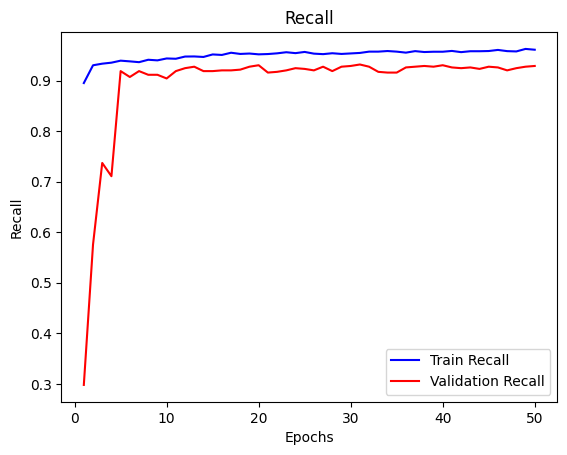

In [ ]:
# Получение значений метрики Recall на обучающем и валидационном наборах данных
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Получение значений эпох
epochs = range(1, len(train_recall) + 1)

# Визуализация метрики Recall
plt.plot(epochs, train_recall, 'b', label='Train Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

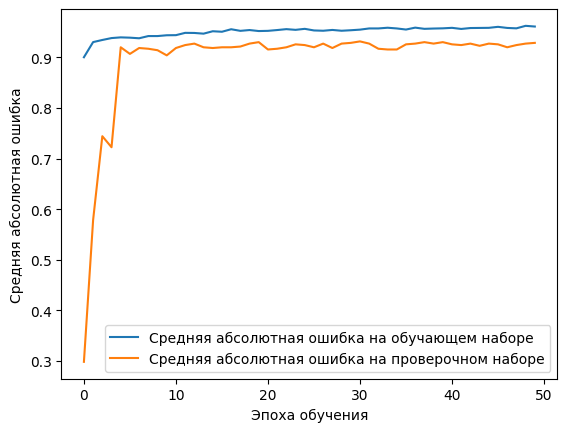

In [ ]:
plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# **Смотрим на результат работы по тестовым данным (которые сеть еще не видела при обучении), проценты точности**

In [ ]:
model=load_model("/content/drive/MyDrive/Colab Notebooks/Стажировка/architecture.hdf5")

In [ ]:
accuracy = model.evaluate((x_test_ohe,x_test_fact,\
x_test_text_MKB,\
x_test_text_cex,x_test_prof), y_test)
print("Accuracy:", accuracy)

25/25 [==============================] - 2s 32ms/step - loss: 0.2615 - recall: 0.9232 - accuracy: 0.9245
Accuracy: [0.2614743709564209, 0.9231753945350647, 0.9244558215141296]


In [ ]:
y_pred = model.predict((x_test_ohe,x_test_fact,x_test_text_MKB,\
                        x_test_text_cex,x_test_prof))

25/25 [==============================] - 1s 27ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

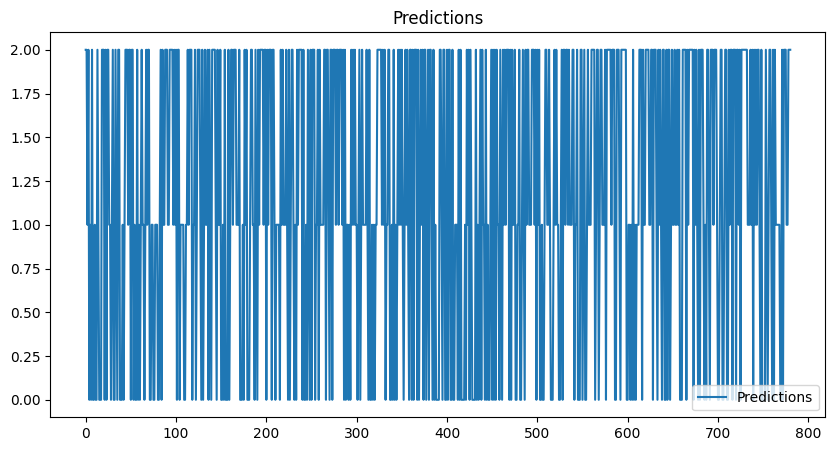

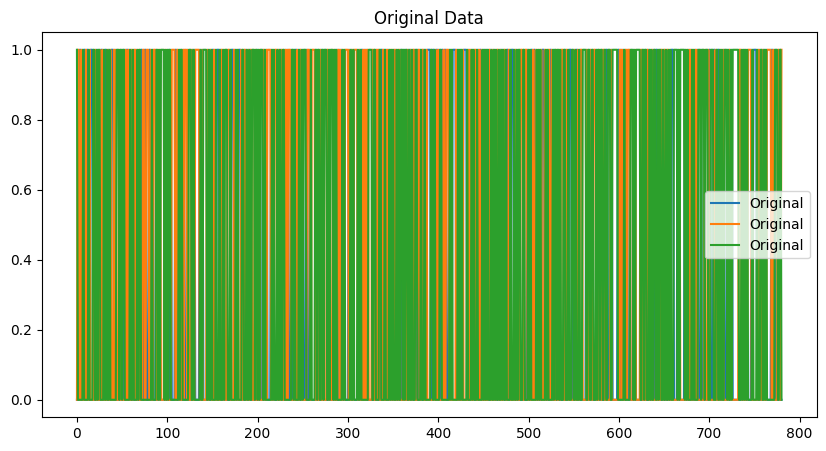

In [ ]:
import matplotlib.pyplot as plt

# Визуализация предсказаний
plt.figure(figsize=(10, 5))
plt.plot(y_pred_classes, label='Предсказания')
plt.legend()
plt.title('предсказания')
plt.show()

# Визуализация оригинальных данных
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Оригинал')
plt.legend()
plt.title('Оригинальные данные')
plt.show()

In [ ]:
evaluation = model.evaluate((x_test_ohe,x_test_fact,x_test_text_MKB,\
                             x_test_text_cex,x_test_prof), y_test)

25/25 [==============================] - 1s 31ms/step - loss: 0.2615 - recall: 0.9232 - accuracy: 0.9245


In [ ]:
accuracy = evaluation[1]

In [ ]:
print('Точность модели:', accuracy)

Точность модели: 0.9231753945350647


In [ ]:
print('Точность модели: %.2f%%' % (accuracy * 100))

Точность модели: 92.32%


In [ ]:
num_outputs = model.output_shape[-1]
print("Количество выходов модели:", num_outputs)

Количество выходов модели: 3


25/25 [==============================] - 0s 15ms/step


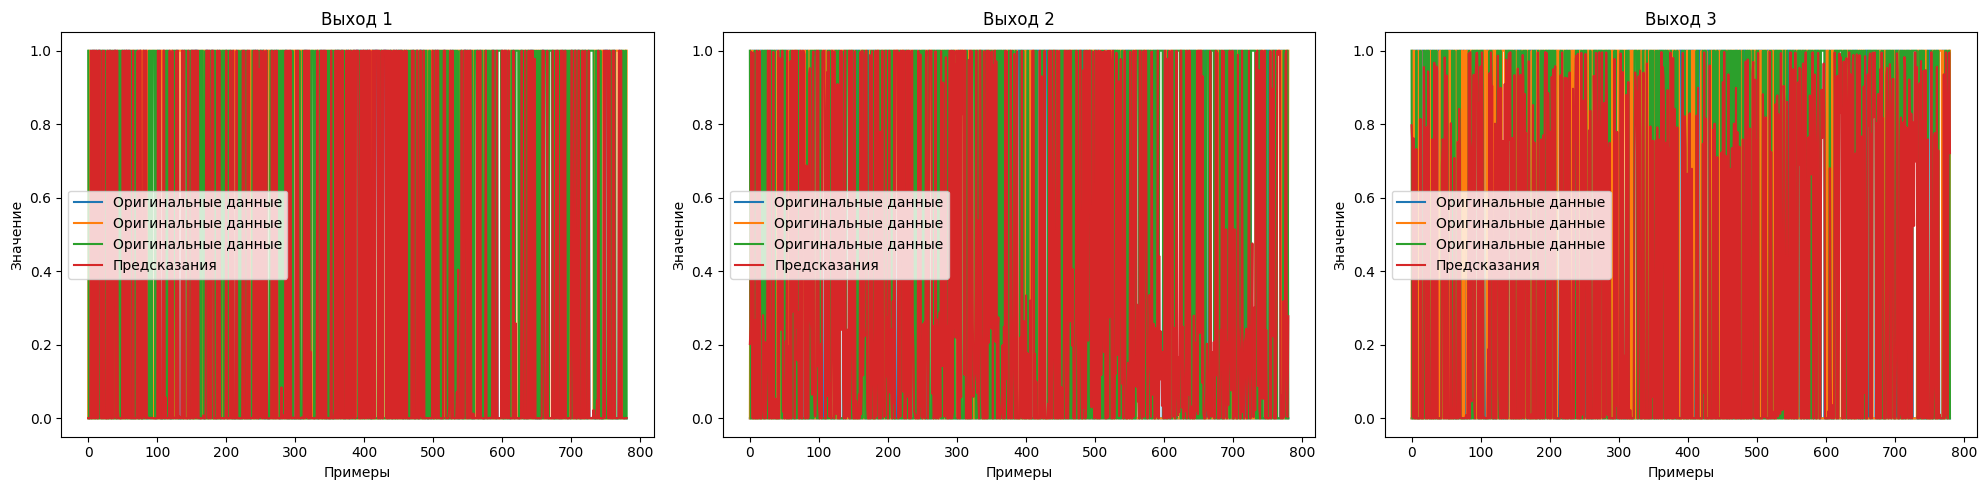

In [ ]:
# Получение предсказаний модели
predictions = model.predict((x_test_ohe, x_test_fact, x_test_text_MKB, x_test_text_cex, x_test_prof))

# Отображение графиков
plt.figure(figsize=(20, 5))

# График для первого выхода модели
plt.subplot(1, 3, 1)
plt.plot(range(len(y_test)), y_test, label='Оригинальные данные')
plt.plot(range(len(predictions)), predictions[:, 0], label='Предсказания')
plt.xlabel('Примеры')
plt.ylabel('Значение')
plt.title('Выход 1')
plt.legend()

# График для второго выхода модели
plt.subplot(1, 3, 2)
plt.plot(range(len(y_test)), y_test, label='Оригинальные данные')
plt.plot(range(len(predictions)), predictions[:, 1], label='Предсказания')
plt.xlabel('Примеры')
plt.ylabel('Значение')
plt.title('Выход 2')
plt.legend()

# График для третьего выхода модели
plt.subplot(1, 3, 3)
plt.plot(range(len(y_test)), y_test, label='Оригинальные данные')
plt.plot(range(len(predictions)), predictions[:, 2], label='Предсказания')
plt.xlabel('Примеры')
plt.ylabel('Значение')
plt.title('Выход 3')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Округление предсказаний до ближайшего целого значения
rounded_predictions = np.argmax(predictions, axis=1)

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

print(cm)

[[216   4   2]
 [  3 222  43]
 [  0   7 284]]


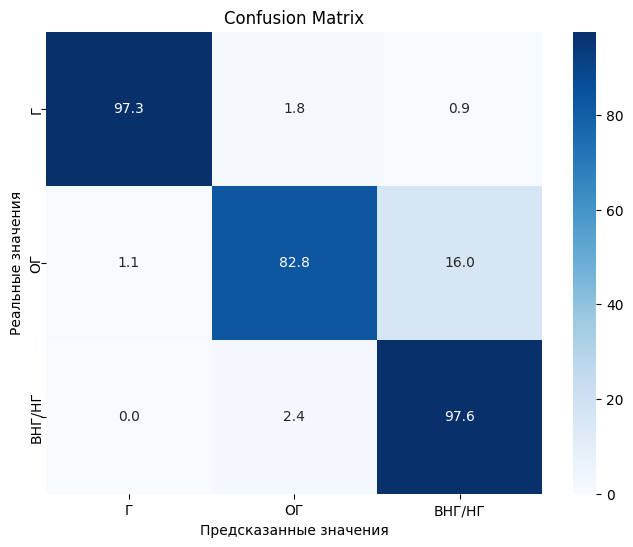

In [ ]:
# Создание списка текстовых меток классов
class_labels = ['Г', 'ОГ', 'ВНГ/НГ']

# Создание матрицы ошибок
cm = confusion_matrix(np.argmax(y_test, axis=1), rounded_predictions)

# Расчет процентов точности
cm_percent = cm / np.sum(cm, axis=1).reshape(-1, 1) * 100

# Создание тепловой карты (heatmap) для визуализации матрицы ошибок с процентами
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Предсказанные значения")
plt.ylabel("Реальные значения")

# Замена значений на осях на текстовые метки с выравниванием по центру
ax.set_xticklabels(class_labels, ha='center')
ax.set_yticklabels(class_labels, ha='center')

plt.show()

В матрице выше мы видим точность предсказания модели по 2-м классам в процентах.

In [ ]:
dl_spavki = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/vred_fact(2).xlsx') #читаем предоставленную таблицу заказчика

In [ ]:
dl_spavki = dl_spavki.astype(str)

In [ ]:
data_dict_str = dl_spavki.set_index('код')['описание'].to_dict()

In [ ]:
data_dict_str

In [ ]:
#data_dict_str = {key: str(value) for key, value in data_dict.items()}

In [ ]:
print("Ключи в data_dict_str:", data_dict_str.keys())

Ключи в data_dict_str: dict_keys(['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2', '1.8', '1.8.1', '1.8.1.1', '1.8.1.2', '1.8.2', '1.8.2.1', '1.8.2.2', '1.8.3', '1.8.3.1', '1.8.3.2', '1.8.4', '1.8.4.1', '1.8.4.2', '1.9', '1.10', '1.11', '1.12', '1.13', '1.14', '1.14.1', '1.14.2', '1.15', '1.15.1', '1.16', '1.17', '1.18', '1.18.1', '1.18.2', '1.18.3', '1.19', '1.19.1', '1.19.2', '1.19.3', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.27.1', '1.27.2', '1.28', '1.29', '1.29.1', '1.29.2', '1.29.3', '1.29.4', '1.29.5', '1.30', '1.30.1', '1.31', '1.32', '1.33', '1.34', '1.34.1', '1.34.2', '1.35', '1.36', '1.36.1', '1.36.2', '1.36.3', '1.37', '1.37.1', '1.37.1.1', '1.37.1.2', '1.37.2', '1.38', '1.39', '1.40', '1.40.1', '1.40.2', '1.41', '1.42', '1.43', '1.43.1', '1.43.2', '1.44', '1.45', '1.45.1', '1.45.2', '1.45.3', '1.46', '1.47', '1.47.1', '1.47.2', '1.47.3', '1.47.4', '1.47.5', '1.47.6', '1.47.7', '1.47.8', '1.47.9', '1.47.10', '1.47.11', '1

In [ ]:
# Получение предсказания для выбранного примера
prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                            x_test_text_MKB[index:index+1],\
                            x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
predicted_classes = np.argmax(prediction, axis=1)
predicted_probabilities = np.max(prediction, axis=1)

# Получение входных данных для выбранного примера
input_data1 = x_test_ohe[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_text_MKB[index]
input_data5 = x_test_text_cex[index]
input_data6 = x_test_prof[index]

class_labels = {
    2: label_encoder.inverse_transform([2])[0],  # ОГ
    1: label_encoder.inverse_transform([1])[0],  # ВНГ
    0: label_encoder.inverse_transform([0])[0]   # Г
}

predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

# Получение МКБ из combined_df
client_prof = combined_df.loc[index, "Профессия"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

#print("вредные факторы:", vred_fact_labels)

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели и вероятности:")
for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
    probability_percent = predicted_probability * 100
    print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
print("МКБ (или список МКБ):", mkb)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________")
print("Профессия клиента: ",client_prof)
print("_________________________________________________________________")
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 31ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ОГ, Вероятность: 74.97%
МКБ (или список МКБ): B35, H52
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

6.1 - Работы с высоким риском падения работника с высоты, а также работы на высоте без применения средств подмащивания, выполняемые на высоте 5 м и более; работы, выполняемые на площадках на расстоянии менее 2 м от неогражденных (при отсутствии защитных ограждений) перепадов по высоте более 5 м либо при высоте ограждений, составляющей менее 1,1 м
4.2.5 - Электромагнитное поле широкополосного спектра частот (5 Гц - 2 кГц, 2 кГц - 400 кГц)
9 - Работы, связанные с техническим обслуживанием электроустановок напряжением 50 В и выше переменного тока и 75 В и выше постоянного тока, проведением в них о

In [ ]:
# Задайте индекс примера, для которого вы хотите получить предсказание
index = 3  # Замените на нужный индекс

# Получение предсказания для выбранного примера
prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                            x_test_text_MKB[index:index+1],\
                            x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
predicted_classes = np.argmax(prediction, axis=1)
predicted_probabilities = np.max(prediction, axis=1)

# Получение входных данных для выбранного примера
input_data1 = x_test_ohe[index]
input_data2 = x_test_fact[index]
input_data3 = x_test_text_MKB[index]
input_data5 = x_test_text_cex[index]
input_data6 = x_test_prof[index]

class_labels = {
    2: label_encoder.inverse_transform([2])[0],  # ОГ
    1: label_encoder.inverse_transform([1])[0],  # ВНГ
    0: label_encoder.inverse_transform([0])[0]   # Г
}

predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

# Получение МКБ из combined_df
client_prof = combined_df.loc[index, "Профессия"]
mkb = combined_df.loc[index, "МКБ"]
vred_fact = combined_df.loc[index, colms5]
vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

# Вывод результатов
print("_________________________________________________________________")
print("Предсказание модели и вероятности:")
for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
    probability_percent = predicted_probability * 100
    print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
print("МКБ (или список МКБ):", mkb)
print("_________________________________________________________________")
print("")
print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
print("")
for col, label in zip(vred_fact_columns, vred_fact_labels):
    print(f"{col} - {label}")
print("_________________________________________________________________")
print("Профессия клиента: ",client_prof)
print("_________________________________________________________________")
print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

1/1 [==============================] - 0s 41ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ОГ, Вероятность: 76.20%
МКБ (или список МКБ): H52
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

6 - Работы на высоте:
4.7 - Параметры охлаждающего микроклимата (температура, влажность, скорость движения воздуха)
9 - Работы, связанные с техническим обслуживанием электроустановок напряжением 50 В и выше переменного тока и 75 В и выше постоянного тока, проведением в них оперативных переключений, выполнением строительных, монтажных, наладочных, ремонтных работ, испытанием и измерением
5.1 - Тяжесть трудового процесса Подъем, перемещение, удержание груза вручную Стереотипные рабочие движения
_________________________________________________________________
Профессия клиента:  Электромонтажник 
____

Функция которая берет случай по индексу таблицы и предоставляет по нему рекомендацию

In [ ]:
def get_prediction(index):
    # Получение предсказания для выбранного примера
    prediction = model.predict((x_test_ohe[index:index+1], x_test_fact[index:index+1],\
                                x_test_text_MKB[index:index+1],\
                                x_test_text_cex[index:index+1], x_test_prof[index:index+1]))
    predicted_classes = np.argmax(prediction, axis=1)
    predicted_probabilities = np.max(prediction, axis=1)

    # Получение входных данных для выбранного примера
    input_data1 = x_test_ohe[index]
    input_data2 = x_test_fact[index]
    input_data3 = x_test_text_MKB[index]
    input_data5 = x_test_text_cex[index]
    input_data6 = x_test_prof[index]

    class_labels = {
        2: label_encoder.inverse_transform([2])[0],  # ОГ
        1: label_encoder.inverse_transform([1])[0],  # ВНГ
        0: label_encoder.inverse_transform([0])[0]   # Г
    }

    predicted_labels = [class_labels[predicted_class] for predicted_class in predicted_classes]

    # Получение МКБ из combined_df
    client_prof = combined_df.loc[index, "Профессия"]
    mkb = combined_df.loc[index, "МКБ"]
    vred_fact = combined_df.loc[index, colms5]
    vred_fact_columns = vred_fact[vred_fact == "1"].index.tolist()
    vred_fact_labels = [data_dict_str.get(key) for key in vred_fact_columns]

    # Вывод результатов
    print("Предсказание модели и вероятности:")
    for predicted_label, predicted_probability in zip(predicted_labels, predicted_probabilities):
        probability_percent = predicted_probability * 100
        print(f"Класс: {predicted_label}, Вероятность: {probability_percent:.2f}%")
    print("МКБ (или список МКБ):", mkb)
    print("_________________________________________________________________")
    print("")
    print("Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)")
    print("")
    for col, label in zip(vred_fact_columns, vred_fact_labels):
        print(f"{col} - {label}")
    print("_________________________________________________________________")
    print("Профессия клиента: ",client_prof)
    print("_________________________________________________________________")
    print("Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые предсказания не являются обязательными к исполнению")

# Использование функции для получения предсказания по заданному индексу
index = 3  # Замените на нужный индекс
get_prediction(index)

1/1 [==============================] - 0s 50ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ОГ, Вероятность: 76.20%
МКБ (или список МКБ): H52
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

6 - Работы на высоте:
4.7 - Параметры охлаждающего микроклимата (температура, влажность, скорость движения воздуха)
9 - Работы, связанные с техническим обслуживанием электроустановок напряжением 50 В и выше переменного тока и 75 В и выше постоянного тока, проведением в них оперативных переключений, выполнением строительных, монтажных, наладочных, ремонтных работ, испытанием и измерением
5.1 - Тяжесть трудового процесса Подъем, перемещение, удержание груза вручную Стереотипные рабочие движения
_________________________________________________________________
Профессия клиента:  Электромонтажник 
____

In [ ]:
get_prediction(4)

1/1 [==============================] - 0s 46ms/step
_________________________________________________________________
Предсказание модели и вероятности:
Класс: ВНГ/НГ, Вероятность: 99.98%
МКБ (или список МКБ): H53
_________________________________________________________________

Вредные факторы и виды работ, которые могут препятствовать деятельности на данном производстве данному пациенту(ке)

4.3.2 - Общая вибрация (транспортная, транспортно-технологическая, технологическая)
4.4 - Шум
18.1 - Категории "A", "B", "BE", трактора и другие самоходные машины, мини-трактора, мотоблоки, автопогрузчики, электрокары, регулировщики и т.п., автомобили всех категорий с ручным управлением для инвалидов, мотоколяски для инвалидов
_________________________________________________________________
Профессия клиента:  Машинист экскаватора-погрузчика
_________________________________________________________________
Стоит обратить внимание, что данная система является рекомендательной, и предоставляемые 

# **Выводы, Резюме, Предложения**

В ходе экспериментов, было создано большое кол-во моделей достигавших заявленной точности, в том числе модели с использованием Embedding и LSTM, финальный вариант модели показавший лучшую точность НС представлен выше.
Модель предсказывает годных (Г) с вероятностью ~98 %, временно негодных (ВНГ) и негодных (НГ) ~98 %, ограниченно годных (ОГ) ~87 %, а также выводит на экран дополнительную информацию по факторам риска и ключевому(-ым) МКБ (заголовкам МКБ). Таким образом основная цель (Цель: Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.) считаю выполненной.
При разъяснении нейронной сети нюансов каким образом происходит подразделение на еще и ограниченно годных возможно улучшение работы модели (Улучшение моей  таблицы на основе приказа н29). Или же при достаточной базе данных от 5 000 примеров профпатологов по каждому из классов (на данный момент из около 30000 примеров после очистки от мусора непригодного для использования только 1000 примеров ОГ и около 100 НГ остальные десятки тысяч примеров либо без заключения либо годные) не годен и ограниченно годен появится возможность обучить модель без искусственного изменения за счет данных из приказа. В случае дальнейшего сотрудничества готов помочь с интеграцией модели в систему заказчика.

- Все также необходимо получить дата-сет с данными с большим кол-вом примеров для классов ограниченно годен и временно негоден (негоден) пока они представлены малым кол-вом примеров (разбалансированы) - иначе нейронную сеть не обучить должным образом. Без конкретных примеров она будет продолжать делать ошибки на классе "ограничено годен", что с медицинской точки зрения неприемлемо.

- При поддержке профпатолога необходимо подробнее разобрать приказ н29 для получения четкого понимания как распределять пациентов на ограниченно годных и негодных для дальнейшей искусственной аугментации данных критериями отбора, это позволит прогнозировать редкие случаи.

- Рекомендательную систему при большем кол-ве примеров можно попытаться  улучшить, к примеру создав отдельно НС для ОГ и НГ для разъяснения по этим классам причины негодности. К примеру для начала добиться отличных результатов по классификации на классы, а затем пропускать классифицированный пример через другой модуль НС для описания этого конкретного случая.